<a href="https://colab.research.google.com/github/DoryAbelman/CARTE-ML-Program/blob/main/Lab_2_2_DA_edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning operates by solving an optimization problem to determine the parameters of a function that best fits the data. However, some parameters - known as hyperparameters - can't be learned through this process, as they set the model structure and guide the optimization procedure. Tuning these hyperparameters is a crucial part of model development and can greatly impact model performance.

Hyperparameter tuning refers to the task of discovering the optimal hyperparameters for a given model and dataset. This process is a key stage in the machine learning workflow. Nevertheless, it poses a challenging task due to its complex nature - there is no universal methodology that applies to all scenarios. The selection of the best hyperparameters relies heavily on the dataset at hand, the chosen model architecture, and the specific learning task. Therefore, identifying the ideal set of hyperparameters is not about finding a one-size-fits-all solution, but rather about employing a mix of intuition, systematic testing, and optimization techniques.

In this lab, we will delve into the fundamentals of hyperparameter tuning, exploring methods such as Grid Search, Cross Validation, and Bayesian Optimization. Let's dive in!

In [2]:
!pip install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.3 MB/s eta 0:00:00


In [3]:
# Import standard libraries
import numpy as np

## Data Preparation

In this lab, we'll be using the HCC dataset to tune our model.

In [5]:
import pandas as pd
hcc = pd.read_csv('https://github.com/alexwolson/carte_workshop_2024/raw/main/data/HCC_all_ML_classification_test_annotated_frags_all_features_combined_4_tumors.csv.gz', compression='gzip')
hcc = hcc.sample(frac=0.2)

In [6]:
# Display the column names
print(hcc.columns)

# Display the top 10 rows
hcc.head(10)

Index(['frag', 'site_key', 'VAF', 'readid', 'csq', 'gene', 'chr', 'pos',
       'alt_match', 'upstream_motif', 'downstream_motif', 'read_cov',
       'detected_read_cov', 'plasma_VAF', 'Corrected_Copy_Number',
       'Corrected_Call', 'sampleID', 'plasmaID', 'tumorID', 'cohort',
       'SNV_Call', 'plasma_cov', 'plasma_TF', 'tumor_cov', 'tumor_TF',
       'unique_PASS_0.1_TMB'],
      dtype='object')


,frag,site_key,VAF,readid,csq,gene,chr,pos,alt_match,upstream_motif,...,sampleID,plasmaID,tumorID,cohort,SNV_Call,plasma_cov,plasma_TF,tumor_cov,tumor_TF,unique_PASS_0.1_TMB
787852,178,chr2-107358846,0.467,A00469:345:HFM23DSX3:3:2534:12445:18693,upstream_gene_variant,AC096669.1,chr2,107358846,0,CTAC,...,TGL49_0302_Cf_R_PE_367_WG_realigned_recalibrat...,TGL49_0302_Cf_R_PE_367_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,WT,NaN,NaN,NaN,NaN,NaN
371276,176,chr8-3573414,0.569,A00469:345:HFM23DSX3:1:1307:5484:20102,intron_variant,CSMD1,chr8,3573414,0,ACCT,...,TGL49_0260_Ct_n_PE_367_WG_realigned_recalibrat...,TGL49_0260_Ct_n_PE_367_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,WT,NaN,NaN,NaN,NaN,NaN
1390783,174,chr5-169843262,0.293,A00827:363:H7M5HDSX2:1:1261:5746:9345,intron_variant,DOCK2,chr5,169843262,0,CAGG,...,HCCCFD_0038_Pl_P_WG_HCC-B-038-T0-P.filter.dedu...,HCCCFD_0038_Pl_P_WG_HCC-B-038-T0-P.filter.dedu...,HCCCFD_0038_Lv_P_WG_HCC-B-038-T0-R.filter.dedu...,HCC_cancer,WT,29.975,0.08223,58.2306,0.642,8.282680
1542333,169,chr7-117589133,0.454,A00827:363:H7M5HDSX2:3:2446:8314:1955,intron_variant,CFTR,chr7,117589133,0,TCTT,...,HCCCFD_0073_Pl_P_WG_HCC-B-073-T0-P.filter.dedu...,HCCCFD_0073_Pl_P_WG_HCC-B-073-T0-P.filter.dedu...,HCCCFD_0073_Lv_P_WG_HCC-B-073-T0-R.filter.dedu...,HCC_cancer,WT,38.510,0.08052,50.7029,0.392,4.076579
30252,158,chr15-27410924,0.455,A00469:349:HFT25DSX3:2:2141:17282:27727,intron_variant,GABRG3,chr15,27410924,1,AAGT,...,TGL49_0197_Cf_R_PE_373_WG_realigned_recalibrat...,TGL49_0197_Cf_R_PE_373_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,MUT,NaN,NaN,NaN,NaN,NaN
628401,156,chr7-53810331,0.242,A00469:345:HFM23DSX3:2:1360:2555:23923,intron_variant&non_coding_transcript_variant,LINC01446,chr7,53810331,0,GGAG,...,TGL49_0266_Pb_U_PE_412_WG_realigned_recalibrat...,TGL49_0266_Pb_U_PE_412_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,WT,NaN,NaN,NaN,NaN,NaN
757725,181,chr4-141005517,0.495,A00469:345:HFM23DSX3:4:1664:29568:23735,intron_variant,RNF150,chr4,141005517,0,TCAT,...,TGL49_0301_Cf_R_PE_382_WG_realigned_recalibrat...,TGL49_0301_Cf_R_PE_382_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,WT,NaN,NaN,NaN,NaN,NaN
272218,164,chr12-21398927,0.137,A00469:345:HFM23DSX3:3:1347:9344:26850,upstream_gene_variant,SLCO1A2,chr12,21398927,0,TACC,...,TGL49_0257_Ct_n_PE_387_WG_realigned_recalibrat...,TGL49_0257_Ct_n_PE_387_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,WT,NaN,NaN,NaN,NaN,NaN
604542,171,chr1-114962195,0.401,A00469:345:HFM23DSX3:4:2573:27525:23109,intron_variant,SYCP1,chr1,114962195,0,TTGG,...,TGL49_0265_Pb_U_PE_382_WG_realigned_recalibrat...,TGL49_0265_Pb_U_PE_382_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,WT,NaN,NaN,NaN,NaN,NaN
993367,165,chr4-87744900,0.368,A00469:347:HFMLJDSX3:3:1117:15320:34569,upstream_gene_variant,RF00019,chr4,87744900,0,GCCA,...,TGL49_0306_Cf_R_PE_381_WG_realigned_recalibrat...,TGL49_0306_Cf_R_PE_381_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,WT,NaN,NaN,NaN,NaN,NaN


In [7]:
# Find how many rows in hcc, then keep only 1% of them

print(f"Number of rows in hcc: {hcc.shape[0]}")
hcc = hcc.sample(frac=0.01)
print(f"New number of rows in hcc: {hcc.shape[0]}")


Number of rows in hcc: 328343
New number of rows in hcc: 3283


In [8]:
## Add the cancer genes

import requests

url = "https://raw.githubusercontent.com/friend1ws/cancer_gene_db/master/CancerGeneCensus/CancerGeneCensus.proc.txt"

response = requests.get(url)

lines = response.text.split('\n')
cancer_genes = [line.split('\t')[0] for line in lines if line]

print(cancer_genes[:5])

# Create the "CANCER_GENE" column
hcc['CANCER_GENE'] = np.where(hcc['gene'].isin(cancer_genes), True, False)

print(hcc['CANCER_GENE'].value_counts()[True])
print(hcc['CANCER_GENE'].value_counts()[False])

['ABI1', 'ABL1', 'ABL2', 'ACKR3', 'ACSL3']
97
3186


In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X_cols = ['frag', 'VAF', 'downstream_motif', 'upstream_motif', 'Corrected_Call', 'alt_match', 'CANCER_GENE']

X_categorical = ['downstream_motif', 'upstream_motif', 'Corrected_Call', 'CANCER_GENE']

X  = hcc[X_cols]

# This applies the fit transform to the data -
# Fits the data by creating a label representation by creating numbers from strings
# Transform makes it happen
X.loc[:,X_categorical] = X[X_categorical].apply(le.fit_transform)

y = hcc['cohort']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Grid Search

With our data ready, we can commence our exploration of hyperparameter tuning. Our initial approach will be grid search, a method that involves constructing a grid of potential hyperparameters and systematically examining the model's performance for each combination. To attain a reliable measure of model performance, grid search is often combined with K-Fold cross-validation. The Grid Search CV process involves:

1. Hyperparameter grid definition: Identify the hyperparameters to be tuned and designate possible values for each one. This forms a grid, where each point represents a unique set of hyperparameters.
2. Cross-validation across folds: For each unique set of hyperparameters, execute a K-Fold Cross-validation on your model and calculate the average error.
3. Hyperparameters selection: Opt for the hyperparameters that result in the best performance (i.e., the lowest error).

Let's delve into the impact of hyperparameter tuning using a simple Random Forest Classifier in the following section.

In [10]:
# Import required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from time import time

print("Setting up a Random Forest Classifier...")
clf = RandomForestClassifier()

print("Defining hyperparameters for Grid Search...")
hyperparameter_search = {
# Choose some hyperparameters by looking up the documentation e.g.
    "n_estimators": [50, 100, 200],
    # Add more
}

print("Setting up Grid Search with 5-fold Cross Validation...")
grid_search_cv = GridSearchCV(
    estimator=clf,
    param_grid=hyperparameter_search,
    scoring=make_scorer(accuracy_score, greater_is_better=True),
    verbose=1,
    n_jobs=-1,  # Use all CPU cores
    cv=5,
)

print("Running Grid Search (This may take a while)...")
start_time = time()
grid_search_cv.fit(X_train, y_train)
end_time = time()

print(f"Grid Search completed in {end_time - start_time:.0f} seconds")

print(f"Best Parameters: {grid_search_cv.best_params_}")
print(f"Best CV Accuracy: {grid_search_cv.best_score_ * 100:.2f}%")

print("Evaluating model on test data...")
clf = grid_search_cv.best_estimator_
test_predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)

print(f"Testing Accuracy: {accuracy * 100:.2f}%")

Setting up a Random Forest Classifier...
Defining hyperparameters for Grid Search...
Setting up Grid Search with 5-fold Cross Validation...
Running Grid Search (This may take a while)...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Grid Search completed in 9 seconds
Best Parameters: {'n_estimators': 100}
Best CV Accuracy: 63.18%
Evaluating model on test data...
Testing Accuracy: 62.56%


## Advanced Parameter Searching

While Grid Search proves effective in many scenarios, its major limitation is its computational demand. The number of models to be trained escalates exponentially with each additional hyperparameter. In our previous example, we had to train a model over five thousand times due to the 1024 combinations ($4^5$) and 5-fold cross-validation. This approach might be feasible for simpler models like Random Forests or Linear/Logistic regression, but it becomes prohibitively time-consuming for deep learning models or when dealing with a large search space.

## Introducing Bayesian Optimization

An alternative hyperparameter tuning technique, Bayesian Optimization, can help mitigate these computational concerns. It's a sequential, model-based optimization method used to find the optimal hyperparameters for a given machine learning model. This technique combines Bayesian inference and optimization to identify promising regions for evaluation, utilizing a surrogate model to approximate the performance of our primary model concerning its hyperparameters.

One of the key advantages of Bayesian optimization is its efficient exploration of the hyperparameter space, which provides a significant edge over exhaustive search methods like grid search. It intelligently selects new configurations based on predictions from the surrogate model, thus converging to the optimal hyperparameters more rapidly and with fewer evaluations.

Next, let's apply Bayesian Optimization for parameter search in our Random Forest model. We'll leverage Optuna, a hyperparameter optimization library that encapsulates this approach.

In [11]:
import optuna
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier


def print_callback(study, trial):
    # Print the trial number, the best value and parameters after each trial
    print(f"\nTrial {trial.number} finished.")
    print(f"Best value after trial {trial.number}: {study.best_value:.3f}")
    print(f"Best params after trial {trial.number}: {study.best_params}")


# Define a function that specifies the model, the search space and trains the model
# Optuna will try to optimize the hyperparameters to maximize the output of this function
def optuna_rf_function(trial):
    hyperparameters = {
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        # Add more again
    }

    model = RandomForestClassifier(**hyperparameters)

    # Evaluate the model using cross-validation and calculate the mean test score
    cv_result = cross_validate(model, X_train, y_train, cv=5, scoring="accuracy")
    return cv_result["test_score"].mean()


# Create an Optuna study object
study = optuna.create_study(direction="maximize")

# Optimize the study using the sampler
study.optimize(
    optuna_rf_function,
    n_trials=10,
    callbacks=[print_callback],
    show_progress_bar=True,
    gc_after_trial=True,
)

[I 2024-04-10 19:08:03,609] A new study created in memory with name: no-name-7738b48b-3551-4b15-83ba-ece012dcc3d2


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-04-10 19:08:04,756] Trial 0 finished with value: 0.6260452652543906 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.6260452652543906.

Trial 0 finished.
Best value after trial 0: 0.626
Best params after trial 0: {'max_depth': 3}
[I 2024-04-10 19:08:06,284] Trial 1 finished with value: 0.6443230128553322 and parameters: {'max_depth': 7}. Best is trial 1 with value: 0.6443230128553322.

Trial 1 finished.
Best value after trial 1: 0.644
Best params after trial 1: {'max_depth': 7}
[I 2024-04-10 19:08:07,648] Trial 2 finished with value: 0.6359456816947311 and parameters: {'max_depth': 4}. Best is trial 1 with value: 0.6443230128553322.

Trial 2 finished.
Best value after trial 2: 0.644
Best params after trial 2: {'max_depth': 7}
[I 2024-04-10 19:08:09,937] Trial 3 finished with value: 0.6458439254028607 and parameters: {'max_depth': 7}. Best is trial 3 with value: 0.6458439254028607.

Trial 3 finished.
Best value after trial 3: 0.646
Best params after trial 3: {'max

In [12]:
def print_accuracy(accuracy, dataset_name):
    print(f"{dataset_name} Accuracy: {accuracy * 100:.2f}%")


# Obtain the best parameters and their corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Display the best parameters and their corresponding accuracy
print(f"Best Parameters: {best_params}")
print_accuracy(best_accuracy, "Best CV")

# Train the best model on the training data
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set and calculate the accuracy
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# Display the test accuracy
print_accuracy(test_accuracy, "Testing")

Best Parameters: {'max_depth': 7}
Best CV Accuracy: 64.58%
Testing Accuracy: 64.54%


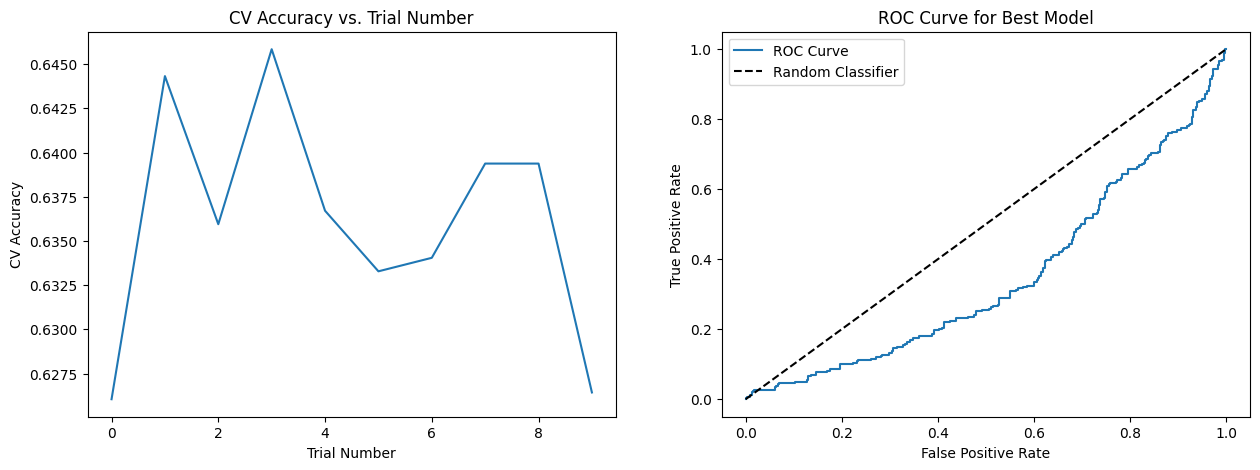

In [16]:
# Make some plots to visualize
from sklearn.metrics import roc_curve

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the CV accuracy for each trial on the first subplot
ax1.plot(study.trials_dataframe()["number"], study.trials_dataframe()["value"])
ax1.set_xlabel("Trial Number")
ax1.set_ylabel("CV Accuracy")
ax1.set_title("CV Accuracy vs. Trial Number")

# Plot the ROC curve on the second subplot
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=pos_label)
ax2.plot(fpr, tpr, label="ROC Curve")
ax2.plot([0, 1], [0, 1], "k--", label="Random Classifier")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve for Best Model")
ax2.legend()

# Display the plot
plt.show()


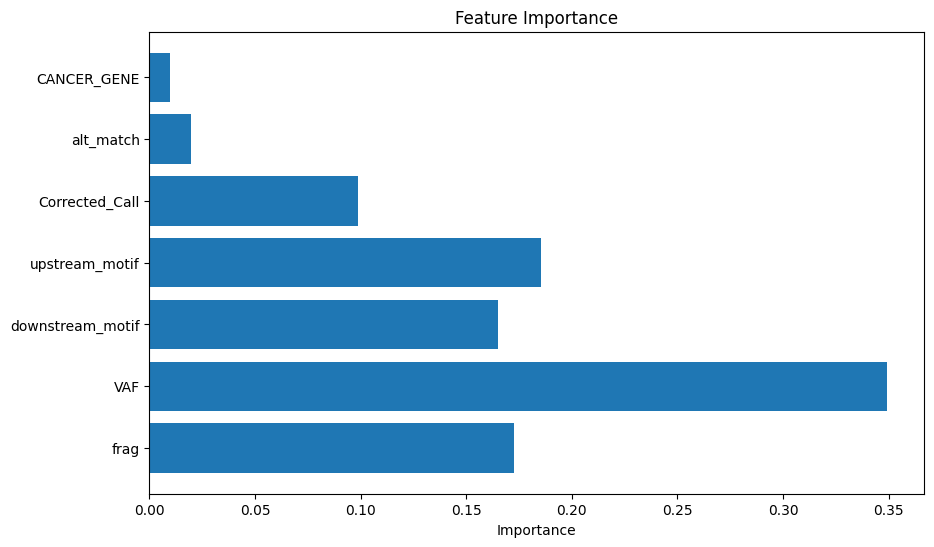

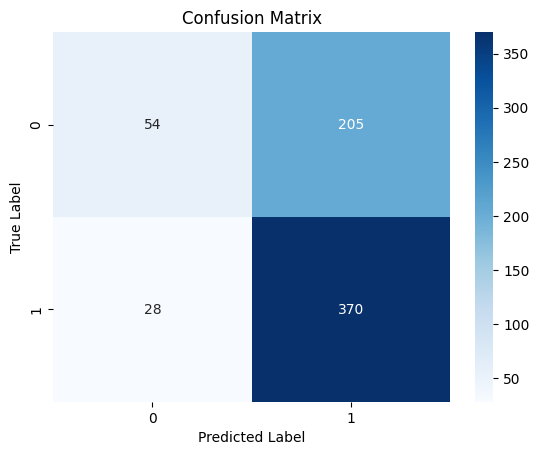

In [41]:
# Plot the feature importance
importances = best_model.feature_importances_
features = X.columns

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(features, importances)
ax.set_xlabel("Importance")
ax.set_title("Feature Importance")
plt.show()

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

# Set labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

##

In [22]:
# Make a classication report

from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

  HCC_cancer       0.66      0.21      0.32       259
 HCC_healthy       0.64      0.93      0.76       398

    accuracy                           0.65       657
   macro avg       0.65      0.57      0.54       657
weighted avg       0.65      0.65      0.59       657



<h2>Explanation of report</h2>


<h3>Precision</h3>
<p><strong>Precision</strong> is the fraction of true positive predictions in the total predicted positives. It quantifies the accuracy of the positive predictions made by the model.</p>
<ul>
    <li><strong>HCC_cancer Precision (0.66):</strong> Indicates that 66% of the instances predicted as HCC cancer were correctly diagnosed.</li>
    <li><strong>HCC_healthy Precision (0.64):</strong> For the instances predicted as healthy, 64% were correctly identified.</li>
</ul>

<h3>Recall</h3>
<p><strong>Recall</strong>, or sensitivity, measures how many of the actual positives the model correctly identified. It's a measure of the model's ability to detect positive cases.</p>
<ul>
    <li><strong>HCC_cancer Recall (0.21):</strong> Only 21% of the actual HCC cancer cases were identified by the model, suggesting a significant number of missed cancer diagnoses.</li>
    <li><strong>HCC_healthy Recall (0.93):</strong> The model correctly identified 93% of the true healthy cases, demonstrating high effectiveness in identifying healthy individuals.</li>
</ul>

<h3>F1-Score</h3>
<p><strong>F1-Score</strong> is the harmonic mean of precision and recall, providing a single metric that balances both, especially important in contexts where both precision and recall are critical.</p>
<ul>
    <li><strong>HCC_cancer F1-Score (0.32):</strong> A low F1-score for HCC cancer indicates a poor balance between precision and recall, with a significant impact from the low recall rate.</li>
    <li><strong>HCC_healthy F1-Score (0.76):</strong> A higher F1-score for healthy individuals suggests a good balance between precision and recall.</li>
</ul>

<h3>Support</h3>
<p><strong>Support</strong> indicates the number of actual occurrences of each class in the dataset, providing context to the performance metrics.</p>
<ul>
    <li><strong>HCC_cancer Support (259):</strong> There are 259 actual cases of HCC cancer in the dataset.</li>
    <li><strong>HCC_healthy Support (398):</strong> There are 398 actual cases of healthy individuals in the dataset.</li>
</ul>

<h3>Overall Metrics</h3>
<p>The report also provides overall metrics such as accuracy, macro average, and weighted average, offering insights into the model's overall performance and its handling of class imbalance.</p>
<ul>
    <li><strong>Accuracy (0.65):</strong> The model correctly identifies the class (cancer or healthy) 65% of the time.</li>
    <li><strong>Macro Avg F1-Score (0.54):</strong> An unweighted mean of the F1-score for each class, indicating overall efficacy.</li>
    <li><strong>Weighted Avg F1-Score (0.59):</strong> Adjusts for class imbalance by giving more weight to the class with more instances, providing a more representative metric of true performance.</li>
</ul>


## Now try to rerun with balanced classes

When we run without, it thinks that the probability of calling a rare event is very low, so doesn't call it. Balancing the classes can help with this.

In [52]:
# Reload in data since previously reduced
hcc = pd.read_csv('https://github.com/alexwolson/carte_workshop_2024/raw/main/data/HCC_all_ML_classification_test_annotated_frags_all_features_combined_4_tumors.csv.gz', compression='gzip')
hcc = hcc.sample(frac=0.2)

print(hcc.columns)

# Display the top 10 rows
hcc.head(10)


Index(['frag', 'site_key', 'VAF', 'readid', 'csq', 'gene', 'chr', 'pos',
       'alt_match', 'upstream_motif', 'downstream_motif', 'read_cov',
       'detected_read_cov', 'plasma_VAF', 'Corrected_Copy_Number',
       'Corrected_Call', 'sampleID', 'plasmaID', 'tumorID', 'cohort',
       'SNV_Call', 'plasma_cov', 'plasma_TF', 'tumor_cov', 'tumor_TF',
       'unique_PASS_0.1_TMB'],
      dtype='object')


,frag,site_key,VAF,readid,csq,gene,chr,pos,alt_match,upstream_motif,...,sampleID,plasmaID,tumorID,cohort,SNV_Call,plasma_cov,plasma_TF,tumor_cov,tumor_TF,unique_PASS_0.1_TMB
652107,191,chr7-11233411,0.325,A00469:345:HFM23DSX3:1:1215:21875:5306,intron_variant&non_coding_transcript_variant,AC004160.1,chr7,11233411,0,TCTT,...,TGL49_0267_Cf_R_PE_371_WG_realigned_recalibrat...,TGL49_0267_Cf_R_PE_371_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,WT,NaN,NaN,NaN,NaN,NaN
917073,155,chr15-42142981,0.129,A00469:347:HFMLJDSX3:2:1549:3061:19852,intron_variant&NMD_transcript_variant,PLA2G4F,chr15,42142981,0,AAAT,...,TGL49_0305_Cf_R_PE_388_WG_realigned_recalibrat...,TGL49_0305_Cf_R_PE_388_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,WT,NaN,NaN,NaN,NaN,NaN
888382,177,chr3-129339031,0.107,A00469:347:HFMLJDSX3:1:1530:9444:21073,downstream_gene_variant,AC137695.1,chr3,129339031,0,TGGG,...,TGL49_0304_Cf_R_PE_449_WG_realigned_recalibrat...,TGL49_0304_Cf_R_PE_449_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,WT,NaN,NaN,NaN,NaN,NaN
367441,121,chr3-160898404,0.378,A00469:345:HFM23DSX3:2:1617:8657:33489,intron_variant,PPM1L,chr3,160898404,0,GGGC,...,TGL49_0259_Ct_n_PE_372_WG_realigned_recalibrat...,TGL49_0259_Ct_n_PE_372_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,WT,NaN,NaN,NaN,NaN,NaN
1099739,177,chr4-46242525,0.303,A00827:363:H7M5HDSX2:2:2409:30092:8328,downstream_gene_variant,AC104072.1,chr4,46242525,0,CCTG,...,HCCCFD_0026_Pl_P_WG_HCC-B-026-T0-P.filter.dedu...,HCCCFD_0026_Pl_P_WG_HCC-B-026-T0-P.filter.dedu...,HCCCFD_0026_Lv_P_WG_HCC-B-026-T0-R.filter.dedu...,HCC_cancer,WT,26.9798,0.02745,50.7275,0.4403,4.172509
1260237,168,chr10-12619257,0.300,A00827:363:H7M5HDSX2:1:2613:16767:28181,intron_variant,CAMK1D,chr10,12619257,0,AGAA,...,HCCCFD_0038_Pl_P_WG_HCC-B-038-T0-P.filter.dedu...,HCCCFD_0038_Pl_P_WG_HCC-B-038-T0-P.filter.dedu...,HCCCFD_0038_Lv_P_WG_HCC-B-038-T0-R.filter.dedu...,HCC_cancer,WT,29.9750,0.08223,58.2306,0.6420,8.282680
160522,184,chr1-213791763,0.239,A00469:349:HFT25DSX3:2:2226:25681:19413,intron_variant&non_coding_transcript_variant,AC096639.1,chr1,213791763,0,CGTC,...,TGL49_0200_Ct_T_PE_316_WG_realigned_recalibrat...,TGL49_0200_Ct_T_PE_316_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,WT,NaN,NaN,NaN,NaN,NaN
1411305,161,chr9-17267718,0.145,A00827:363:H7M5HDSX2:4:2251:16640:24205,intron_variant,CNTLN,chr9,17267718,0,GAAA,...,HCCCFD_0072_Pl_P_WG_HCC-B-072-T0-P.filter.dedu...,HCCCFD_0072_Pl_P_WG_HCC-B-072-T0-P.filter.dedu...,HCCCFD_0072_Lv_P_WG_HCC-B-072-T0-R.filter.dedu...,HCC_cancer,WT,40.0906,0.00000,100.2630,0.3481,3.426057
255220,181,chr1-95751826,0.113,A00469:345:HFM23DSX3:4:2136:20030:14074,intron_variant&non_coding_transcript_variant,AL356479.1,chr1,95751826,0,AAGC,...,TGL49_0256_Ct_n_PE_395_WG_realigned_recalibrat...,TGL49_0256_Ct_n_PE_395_WG_realigned_recalibrat...,HCCCFD_0085_Lv_P_WG_HCC-B-085-T0-R.filter.dedu...,HCC_healthy,WT,NaN,NaN,NaN,NaN,NaN
1181441,173,chr8-87030697,0.542,A00827:363:H7M5HDSX2:4:1364:16658:11209,intron_variant,CNBD1,chr8,87030697,0,CAGA,...,HCCCFD_0030_Pl_P_WG_HCC-B-030-T0-P.filter.dedu...,HCCCFD_0030_Pl_P_WG_HCC-B-030-T0-P.filter.dedu...,HCCCFD_0030_Lv_P_WG_HCC-B-030-T0-R.filter.dedu...,HCC_cancer,WT,25.0462,0.02397,61.5122,0.7608,5.387957


In [55]:
## Add the cancer genes
hcc['CANCER_GENE'] = np.where(hcc['gene'].isin(cancer_genes), True, False)

print(hcc['CANCER_GENE'].value_counts()[True])
print(hcc['CANCER_GENE'].value_counts()[False])

# Create a balanced dataset
hcc_cancer = hcc[hcc['cohort'] == 'HCC_cancer']
hcc_healthy = hcc[hcc['cohort'] == 'HCC_healthy']

hcc_balanced = pd.concat([hcc_healthy.sample(frac=0.5), hcc_cancer])

# Check if the number of rows is greater than 4,000
if len(hcc_balanced) > 4000:
    # Calculate the fraction to downsample to 4,000 rows while maintaining the proportion
    frac_to_keep = 4000 / len(hcc_balanced)

    # Downsample both datasets before concatenation
    downsized_cancer = hcc_cancer.sample(frac=frac_to_keep * 0.5)  # Adjusting fraction for hcc_cancer
    downsized_healthy = hcc_healthy.sample(frac=frac_to_keep)  # Keeping the proportion for hcc_healthy

    # Concatenate the downsampled datasets
    hcc_balanced = pd.concat([downsized_cancer, downsized_healthy])


le = LabelEncoder()

X_cols = ['frag', 'VAF', 'downstream_motif', 'upstream_motif', 'Corrected_Call', 'alt_match', 'CANCER_GENE']

X_categorical = ['downstream_motif', 'upstream_motif', 'Corrected_Call', 'CANCER_GENE']

X = hcc_balanced[X_cols]

# This applies the fit transform to the data -
# Fits the data by creating a label representation by creating numbers from strings
# Transform makes it happen

X.loc[:,X_categorical] = X[X_categorical].apply(le.fit_transform)
y = hcc_balanced['cohort']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Grid Search
#
# With our data ready, we can commence our exploration of hyperparameter tuning. Our initial approach will be grid search, a method that involves constructing a grid of potential hyperparameters and systematically examining the model's performance for each combination. To attain a reliable measure of model performance, grid search is often combined with K-Fold cross-validation. The Grid Search CV process involves:
#
# 1. Hyperparameter grid definition: Identify the hyperparameters to be tuned and designate possible values for each one. This forms a grid, where each point represents a unique set of hyperparameters.
# 2. Cross-validation across folds: For each unique set of hyperparameters, execute a K-Fold Cross-validation on your model and calculate the average error.
# 3. Hyperparameters selection: Opt for the hyperparameters that result in the best performance (i.e., the lowest error).
#
# Let's delve into the impact of hyperparameter tuning using a simple Random Forest Classifier in the following section.
# Import required libraries

print("Setting up a Random Forest Classifier...")
clf = RandomForestClassifier()

print("Defining hyperparameters for Grid Search...")
hyperparameter_search = {
# Choose some hyperparameters by looking up the documentation e.g.
    "n_estimators": [50, 100, 200],
    # Add more
}

print("Setting up Grid Search with 5-fold Cross Validation...")
grid_search_cv = GridSearchCV(
    estimator=clf,
    param_grid=hyperparameter_search,
    scoring=make_scorer(accuracy_score, greater_is_better=True),
    verbose=1,
    n_jobs=-1,  # Use all CPU cores
    cv=5,
)

print("Running Grid Search (This may take a while)...")
start_time = time()
grid_search_cv.fit(X_train, y_train)
end_time = time()

print(f"Grid Search completed in {end_time - start_time:.0f} seconds")

print(f"Best Parameters: {grid_search_cv.best_params_}")
print(f"Best CV Accuracy: {grid_search_cv.best_score_ * 100:.2f}%")

print("Evaluating model on test data...")
clf = grid_search_cv.best_estimator_
test_predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)

print(f"Testing Accuracy: {accuracy * 100:.2f}%")

## Advanced Parameter Searching
def print_callback(study, trial):
    # Print the trial number, the best value and parameters after each trial
    print(f"\nTrial {trial.number} finished.")
    print(f"Best value after trial {trial.number}: {study.best_value:.3f}")
    print(f"Best params after trial {trial.number}: {study.best_params}")


# Define a function that specifies the model, the search space and trains the model
# Optuna will try to optimize the hyperparameters to maximize the output of this function
def optuna_rf_function(trial):
    hyperparameters = {
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        # Add more again
    }

    model = RandomForestClassifier(**hyperparameters)

    # Evaluate the model using cross-validation and calculate the mean test score
    cv_result = cross_validate(model, X_train, y_train, cv=5, scoring="accuracy")
    return cv_result["test_score"].mean()


# Create an Optuna study object
study = optuna.create_study(direction="maximize")

# Optimize the study using the sampler
study.optimize(
    optuna_rf_function,
    n_trials=10,
    callbacks=[print_callback],
    show_progress_bar=True,
    gc_after_trial=True,
)

def print_accuracy(accuracy, dataset_name):
    print(f"{dataset_name} Accuracy: {accuracy * 100:.2f}%")


# Obtain the best parameters and their corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Display the best parameters and their corresponding accuracy
print(f"Best Parameters: {best_params}")
print_accuracy(best_accuracy, "Best CV")

# Train the best model on the training data
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test set and calculate the accuracy
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# Display the test accuracy
print_accuracy(test_accuracy, "Testing")

9223
319120
Setting up a Random Forest Classifier...
Defining hyperparameters for Grid Search...
Setting up Grid Search with 5-fold Cross Validation...
Running Grid Search (This may take a while)...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[I 2024-04-10 19:49:13,208] A new study created in memory with name: no-name-cf6c03e1-5c16-47df-acac-acbdea102d18


Grid Search completed in 8 seconds
Best Parameters: {'n_estimators': 50}
Best CV Accuracy: 75.92%
Evaluating model on test data...
Testing Accuracy: 74.79%


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-04-10 19:49:14,669] Trial 0 finished with value: 0.7674421510320355 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.7674421510320355.

Trial 0 finished.
Best value after trial 0: 0.767
Best params after trial 0: {'max_depth': 3}
[I 2024-04-10 19:49:17,096] Trial 1 finished with value: 0.7679758394436789 and parameters: {'max_depth': 7}. Best is trial 1 with value: 0.7679758394436789.

Trial 1 finished.
Best value after trial 1: 0.768
Best params after trial 1: {'max_depth': 7}
[I 2024-04-10 19:49:18,436] Trial 2 finished with value: 0.7669073916737468 and parameters: {'max_depth': 3}. Best is trial 1 with value: 0.7679758394436789.

Trial 2 finished.
Best value after trial 2: 0.768
Best params after trial 2: {'max_depth': 7}
[I 2024-04-10 19:49:19,970] Trial 3 finished with value: 0.7682435761050384 and parameters: {'max_depth': 5}. Best is trial 3 with value: 0.7682435761050384.

Trial 3 finished.
Best value after trial 3: 0.768
Best params after trial 3: {'max

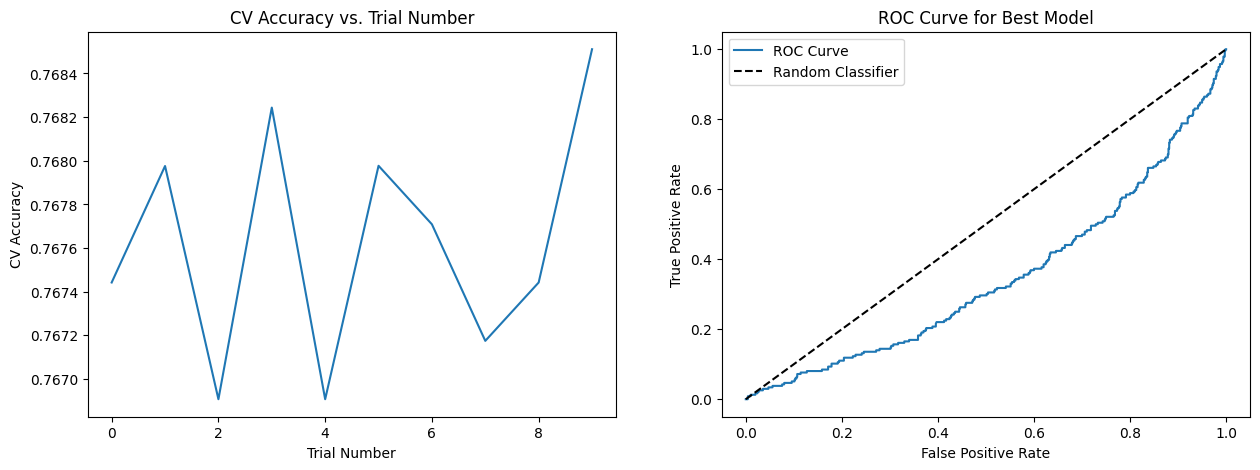

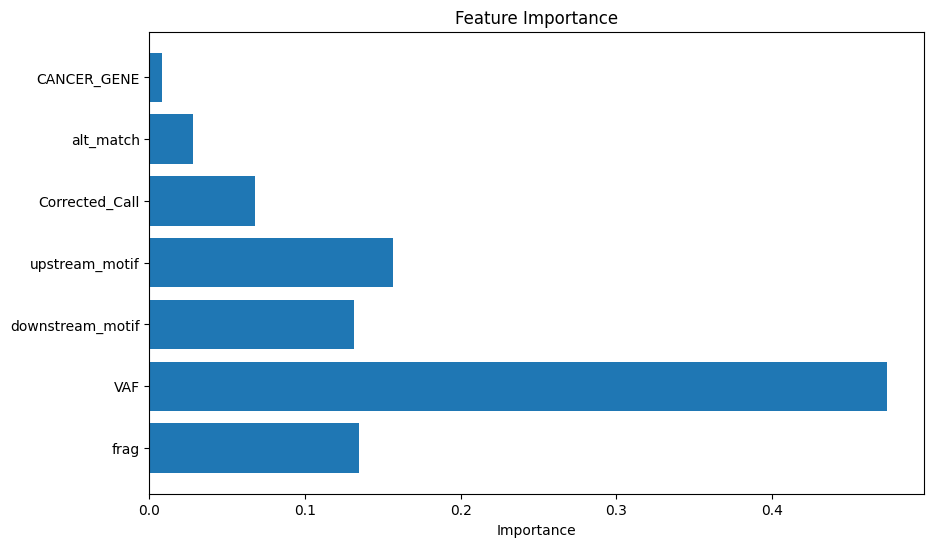

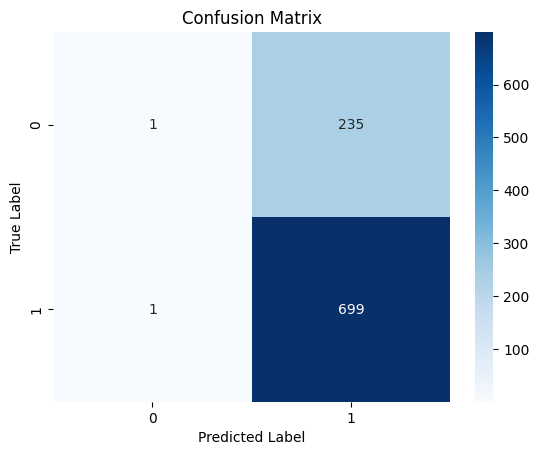

In [56]:
## Now plot

# Make some plots to visualize
from sklearn.metrics import roc_curve

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the CV accuracy for each trial on the first subplot
ax1.plot(study.trials_dataframe()["number"], study.trials_dataframe()["value"])
ax1.set_xlabel("Trial Number")
ax1.set_ylabel("CV Accuracy")
ax1.set_title("CV Accuracy vs. Trial Number")

# Plot the ROC curve on the second subplot
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=pos_label)
ax2.plot(fpr, tpr, label="ROC Curve")
ax2.plot([0, 1], [0, 1], "k--", label="Random Classifier")
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve for Best Model")
ax2.legend()

# Display the plot
plt.show()

# Plot the feature importance
importances = best_model.feature_importances_
features = X.columns

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(features, importances)
ax.set_xlabel("Importance")
ax.set_title("Feature Importance")
plt.show()

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")

# Set labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [57]:
# Make a classication report

from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

  HCC_cancer       0.50      0.00      0.01       236
 HCC_healthy       0.75      1.00      0.86       700

    accuracy                           0.75       936
   macro avg       0.62      0.50      0.43       936
weighted avg       0.69      0.75      0.64       936



## Predict now based on if the fragment has a tumor SNV or not